<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [26]:
import pandas as pd

df = pd.read_csv('nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


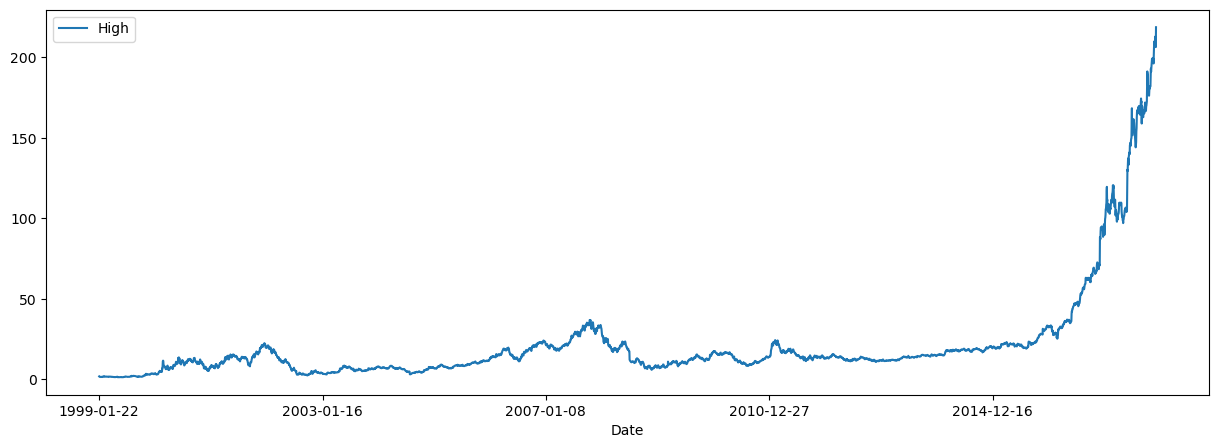

In [27]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [28]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [30]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [31]:
df = df.dropna()

In [32]:
df.shape

(4733, 7)

In [33]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [34]:
import numpy as np 

def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [35]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features
features = df[['Open', 'High', 'Low', 'Close']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=10, step=15)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (315, 10, 4)
Shape of data y: (315,)
Shape of data x_train: (227, 10, 4)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 4)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 4)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


## B. Defining Neural Networks

In [36]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [37]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 935.5425, Val loss: 1320.6642, Best Val loss: 1320.6642
Epoch 2/100, Train loss: 1745.7535, Val loss: 1241.4469, Best Val loss: 1241.4469
Epoch 3/100, Train loss: 674.4765, Val loss: 1212.6870, Best Val loss: 1212.6870
Epoch 4/100, Train loss: 962.5457, Val loss: 1200.6567, Best Val loss: 1200.6567
Epoch 5/100, Train loss: 751.3422, Val loss: 1192.6577, Best Val loss: 1192.6577
Epoch 6/100, Train loss: 685.1017, Val loss: 1189.5709, Best Val loss: 1189.5709
Epoch 7/100, Train loss: 668.0050, Val loss: 1188.8086, Best Val loss: 1188.8086
Epoch 8/100, Train loss: 681.7660, Val loss: 1190.2205, Best Val loss: 1188.8086
Epoch 9/100, Train loss: 667.6975, Val loss: 1192.2318, Best Val loss: 1188.8086
Epoch 10/100, Train loss: 671.0690, Val loss: 1195.8881, Best Val loss: 1188.8086
Epoch 11/100, Train loss: 1264.0212, Val loss: 1195.8010, Best Val loss: 1188.8086
Epoch 12/100, Train loss: 665.1893, Val loss: 1186.3091, Best Val loss: 1186.3091
Epoch 13/100, Train los

#### Visualizing the model performance

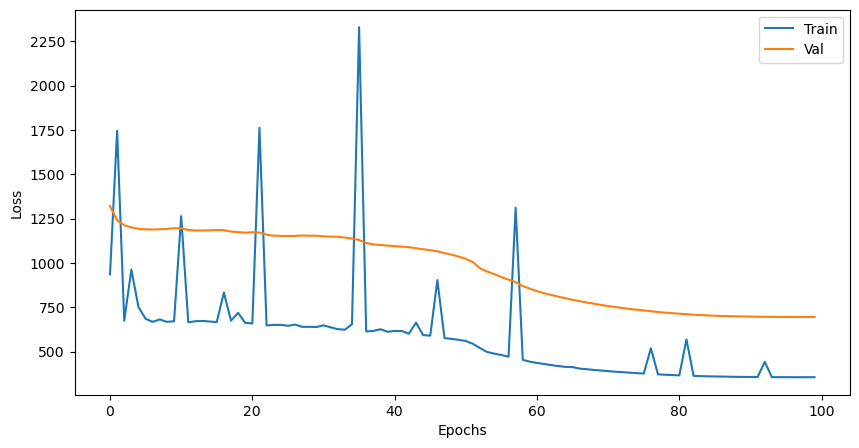

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [39]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

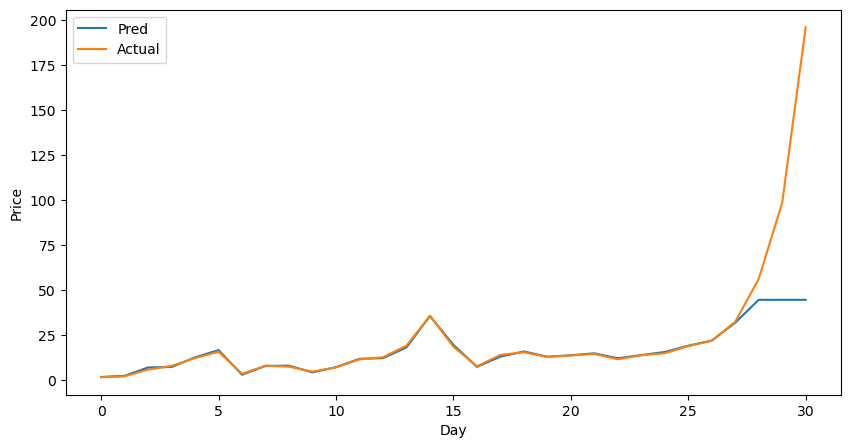

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

## E. Experiments for Window_size and Step.

In [41]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def data_processing_with_parameter(window_size=10, step=15, batch_size=32, features=df[['Open', 'High', 'Low', 'Close']]):
    # Select features
    # features = df[['Open', 'High', 'Low', 'Close']]
    labels = df['High'].shift(-1)  # Next day's high price as label

    X, y = create_sequences(features, labels, window_size=window_size, step=step)

    print(f'Shape of data X: {X.shape}')
    print(f'Shape of data y: {y.shape}')

    # split the hold-out tests
    ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
    x_test = X[ind]
    y_test = y[ind]
    all_ind = np.arange(len(X))
    remains_ind = np.delete(all_ind, ind)

    X = X[remains_ind]
    y = y[remains_ind]

    # shuffle dataset
    ind = np.random.permutation(len(X))
    X = X[ind]
    y = y[ind]
    split_point = int(X.shape[0]*0.8)

    x_train = X[:split_point]
    y_train = y[:split_point]
    x_val = X[split_point:]
    y_val = y[split_point:]

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()

    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    batch_size = batch_size

    # Create datasets
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    test_dataset = TensorDataset(x_test, y_test)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

    return train_loader, val_loader, test_loader

In [42]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def run(train_loader, val_loader, epochs=100, input_dim=4):
    train_losses = []
    val_losses = []

    epochs = 100
    model = LSTMModel(input_dim=input_dim, hidden_dim=500, num_layers=2, output_dim=1).cuda()

    best_val_loss = float('inf')

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        total_loss = 0.0

        for features, labels in train_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Learning rate update
        lr_scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.cuda()
                labels = labels.cuda()
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            if epoch > 94:
                print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

        # Store performance
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses, best_val_loss, model

def predict(test_loader, model):
    # Load the trained weights
    model.load_state_dict(torch.load('best_model.pth'))

    # Set the model to evaluation mode
    model.eval()

    pred_value = []
    actual_value = []

    with torch.no_grad():
        for features, labels in test_loader:
            features = features.cuda()
            outputs = model(features).squeeze(-1)
            pred_value.append(outputs.cpu())
            actual_value.append(labels)

    pred_value = torch.cat(pred_value)
    actual_value = torch.cat(actual_value)

    return pred_value, actual_value

In [43]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt

parameter_list = [
    {'window_size': 5, 'step': 5},
    {'window_size': 5, 'step': 10},
    {'window_size': 5, 'step': 15},
    {'window_size': 5, 'step': 20},
    {'window_size': 5, 'step': 30},
    {'window_size': 10, 'step': 5},
    {'window_size': 15, 'step': 5},
    {'window_size': 20, 'step': 5},
    {'window_size': 30, 'step': 5},
]

the_best_val_loss = float('inf')
best_window_size = None
best_step = None
best_pred_value = None
best_actual_value = None
best_train_losses = None
best_val_losses = None

results = []

for parameter in parameter_list:
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    random.seed(42)
    window_size = parameter['window_size']
    step = parameter['step']
    print(f'< Window size: {window_size}, Step: {step} >')
    train_loader, val_loader, test_loader = data_processing_with_parameter(window_size=window_size, step=step)
    train_losses, val_losses, best_val_loss, model = run(train_loader, val_loader, epochs=100)
    pred_value, actual_value = predict(test_loader=test_loader, model=model)
    
    print('\n')

    if best_val_loss < the_best_val_loss:
        the_best_val_loss = best_val_loss
        best_window_size = window_size
        best_step = step
        best_pred_value = pred_value
        best_actual_value = actual_value
        best_train_losses = train_losses
        best_val_losses = val_losses
        
    results.append({
        'window_size': window_size,
        'step': step,
        'Train Loss': train_losses[-1],
        'Val Loss': val_losses[-1],
        'Best Val Loss': best_val_loss
    })

# Create a result table
df_results = pd.DataFrame(results)
print("\n===== Experiment Results =====")
print(df_results)
df_results.to_csv("experiment_results1.csv", index=False)

< Window size: 5, Step: 5 >
Shape of data X: (946, 5, 4)
Shape of data y: (946,)
Number of samples in training and validation are 681 and 171.


  0%|          | 0/100 [00:00<?, ?it/s]



< Window size: 5, Step: 10 >
Shape of data X: (473, 5, 4)
Shape of data y: (473,)
Number of samples in training and validation are 340 and 86.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 25.7596, Val loss: 124.4855, Best Val loss: 124.4855
Epoch 97/100, Train loss: 25.7500, Val loss: 124.4494, Best Val loss: 124.4494
Epoch 98/100, Train loss: 25.7848, Val loss: 124.4382, Best Val loss: 124.4382
Epoch 99/100, Train loss: 25.7359, Val loss: 124.4331, Best Val loss: 124.4331
Epoch 100/100, Train loss: 25.7401, Val loss: 124.4316, Best Val loss: 124.4316


< Window size: 5, Step: 15 >
Shape of data X: (316, 5, 4)
Shape of data y: (316,)
Number of samples in training and validation are 228 and 57.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 76.9153, Val loss: 188.0221, Best Val loss: 188.0221
Epoch 97/100, Train loss: 138.5267, Val loss: 187.9918, Best Val loss: 187.9918
Epoch 98/100, Train loss: 77.7900, Val loss: 187.9661, Best Val loss: 187.9661
Epoch 99/100, Train loss: 76.8940, Val loss: 187.9548, Best Val loss: 187.9548
Epoch 100/100, Train loss: 76.8690, Val loss: 187.9526, Best Val loss: 187.9526


< Window size: 5, Step: 20 >
Shape of data X: (237, 5, 4)
Shape of data y: (237,)
Number of samples in training and validation are 171 and 43.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 134.1736, Val loss: 403.6479, Best Val loss: 403.6479
Epoch 97/100, Train loss: 83.3928, Val loss: 403.5879, Best Val loss: 403.5879
Epoch 98/100, Train loss: 83.3416, Val loss: 403.5572, Best Val loss: 403.5572
Epoch 99/100, Train loss: 83.5828, Val loss: 403.5439, Best Val loss: 403.5439
Epoch 100/100, Train loss: 134.1445, Val loss: 403.5409, Best Val loss: 403.5409


< Window size: 5, Step: 30 >
Shape of data X: (158, 5, 4)
Shape of data y: (158,)
Number of samples in training and validation are 114 and 29.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 191.7126, Val loss: 376.4047, Best Val loss: 376.4047
Epoch 97/100, Train loss: 208.1674, Val loss: 376.3608, Best Val loss: 376.3608
Epoch 98/100, Train loss: 150.9357, Val loss: 376.3326, Best Val loss: 376.3326
Epoch 99/100, Train loss: 150.9137, Val loss: 376.3204, Best Val loss: 376.3204
Epoch 100/100, Train loss: 150.9401, Val loss: 376.3175, Best Val loss: 376.3175


< Window size: 10, Step: 5 >
Shape of data X: (945, 10, 4)
Shape of data y: (945,)
Number of samples in training and validation are 680 and 171.


  0%|          | 0/100 [00:00<?, ?it/s]



< Window size: 15, Step: 5 >
Shape of data X: (944, 15, 4)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]



< Window size: 20, Step: 5 >
Shape of data X: (943, 20, 4)
Shape of data y: (943,)
Number of samples in training and validation are 679 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 6.9127, Val loss: 8.4800, Best Val loss: 8.4800
Epoch 97/100, Train loss: 6.9058, Val loss: 8.4769, Best Val loss: 8.4769
Epoch 99/100, Train loss: 6.9079, Val loss: 8.4768, Best Val loss: 8.4768
Epoch 100/100, Train loss: 6.9059, Val loss: 8.4767, Best Val loss: 8.4767


< Window size: 30, Step: 5 >
Shape of data X: (941, 30, 4)
Shape of data y: (941,)
Number of samples in training and validation are 677 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 7.3601, Val loss: 8.9181, Best Val loss: 8.9181
Epoch 97/100, Train loss: 7.3642, Val loss: 8.9041, Best Val loss: 8.9041



===== Experiment Results =====
   window_size  step  Train Loss    Val Loss  Best Val Loss
0            5     5    5.234203    7.690431       7.412310
1            5    10   25.740125  124.431597     124.431597
2            5    15   76.869007  187.952644     187.952644
3            5    20  134.144480  403.540855     403.540855
4            5    30  150.940112  376.317535     376.317535
5           10     5    5.232036    8.394690       8.278263
6           15     5    6.081079    7.308459       7.186388
7           20     5    6.905857    8.476655       8.476655
8           30     5    7.352250    8.907722       8.904067


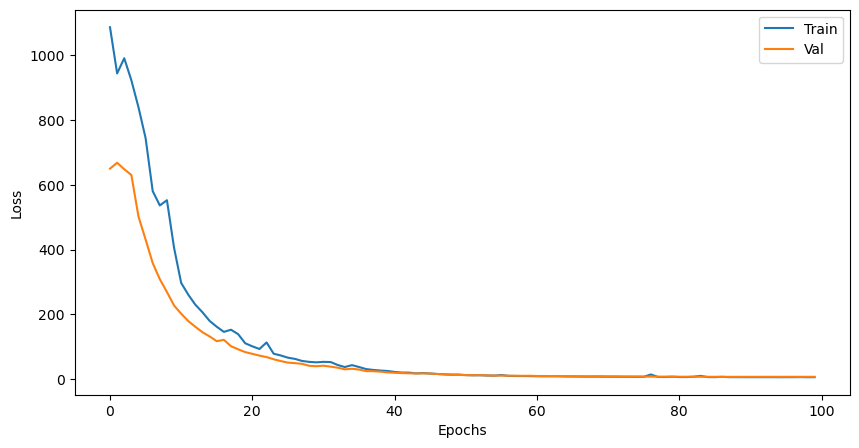

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(best_train_losses)
plt.plot(best_val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

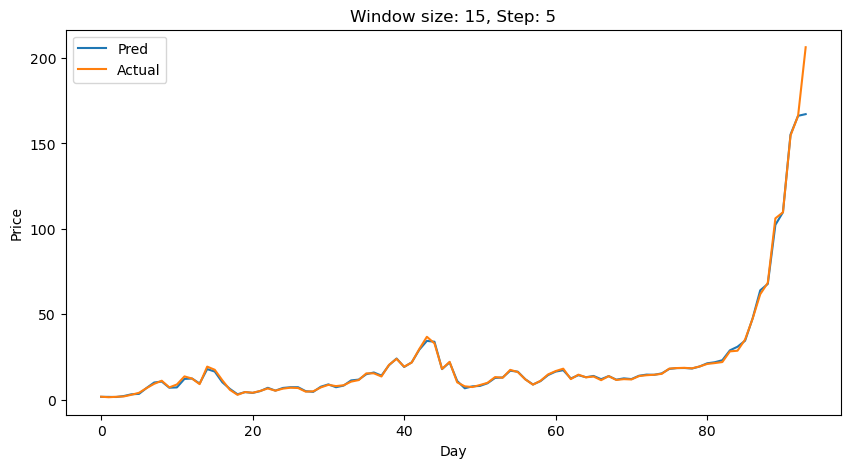

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(best_pred_value[:])
plt.plot(best_actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])
plt.title(f'Window size: {best_window_size}, Step: {best_step}')
plt.show()

## F. Experiments for different features.

In [46]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random

parameter_list = [
    {'features': df[['Open', 'High', 'Low', 'Close']]},
    {'features': df[['Open', 'High', 'Low', 'Close', 'Volume']]},
    {'features': df[['Open']]},
    {'features': df[['High']]},
    {'features': df[['Low']]},
    {'features': df[['Close']]},
    {'features': df[['Open', 'Close']]},
    {'features': df[['Open', 'High', 'Close']]},
]

the_best_val_loss = float('inf')
best_window_size = None
best_step = None
best_pred_value = None
best_actual_value = None
best_train_losses = None
best_val_losses = None

results = []

for parameter in parameter_list:
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    random.seed(42)
    print(f'< features: {parameter['features'].columns.tolist()} >')
    train_loader, val_loader, test_loader = data_processing_with_parameter(window_size=15,step=5,features=parameter['features'])
    train_losses, val_losses, best_val_loss, model = run(train_loader, val_loader, epochs=100, input_dim=len(parameter['features'].columns.tolist()))
    pred_value, actual_value = predict(test_loader=test_loader, model=model)
    
    print('\n')

    if best_val_loss < the_best_val_loss:
        the_best_val_loss = best_val_loss
        best_pred_value = pred_value
        best_actual_value = actual_value
        best_train_losses = train_losses
        best_val_losses = val_losses
        
    results.append({
        'window_size':15,
        'step': 5,
        'features': parameter['features'].columns.tolist(),
        'Train Loss': train_losses[-1],
        'Val Loss': val_losses[-1],
        'Best Val Loss': best_val_loss
    })

# Create a result table
df_results = pd.DataFrame(results)
print("\n===== Experiment Results =====")
print(df_results)
df_results.to_csv("experiment_results2.csv", index=False)

< features: ['Open', 'High', 'Low', 'Close'] >
Shape of data X: (944, 15, 4)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]



< features: ['Open', 'High', 'Low', 'Close', 'Volume'] >
Shape of data X: (944, 15, 5)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]



< features: ['Open'] >
Shape of data X: (944, 15, 1)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 11.0211, Val loss: 12.3205, Best Val loss: 12.3205
Epoch 97/100, Train loss: 11.0116, Val loss: 12.3156, Best Val loss: 12.3156
Epoch 98/100, Train loss: 11.0149, Val loss: 12.3148, Best Val loss: 12.3148
Epoch 99/100, Train loss: 11.0065, Val loss: 12.3136, Best Val loss: 12.3136
Epoch 100/100, Train loss: 11.0234, Val loss: 12.3134, Best Val loss: 12.3134


< features: ['High'] >
Shape of data X: (944, 15, 1)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 11.0658, Val loss: 12.6630, Best Val loss: 12.6630
Epoch 99/100, Train loss: 11.0406, Val loss: 12.6627, Best Val loss: 12.6627
Epoch 100/100, Train loss: 11.0581, Val loss: 12.6624, Best Val loss: 12.6624


< features: ['Low'] >
Shape of data X: (944, 15, 1)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 11.3806, Val loss: 13.3229, Best Val loss: 13.3229
Epoch 97/100, Train loss: 11.3796, Val loss: 13.3100, Best Val loss: 13.3100
Epoch 98/100, Train loss: 11.3760, Val loss: 13.3042, Best Val loss: 13.3042
Epoch 99/100, Train loss: 11.3635, Val loss: 13.3042, Best Val loss: 13.3042


< features: ['Close'] >
Shape of data X: (944, 15, 1)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 11.2408, Val loss: 12.3980, Best Val loss: 12.3980
Epoch 97/100, Train loss: 11.2436, Val loss: 12.3910, Best Val loss: 12.3910
Epoch 98/100, Train loss: 11.2380, Val loss: 12.3883, Best Val loss: 12.3883
Epoch 99/100, Train loss: 11.2233, Val loss: 12.3879, Best Val loss: 12.3879
Epoch 100/100, Train loss: 11.2486, Val loss: 12.3876, Best Val loss: 12.3876


< features: ['Open', 'Close'] >
Shape of data X: (944, 15, 2)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 6.9007, Val loss: 8.1271, Best Val loss: 8.1271
Epoch 97/100, Train loss: 6.8522, Val loss: 8.1259, Best Val loss: 8.1259
Epoch 98/100, Train loss: 6.8772, Val loss: 8.1255, Best Val loss: 8.1255
Epoch 99/100, Train loss: 6.9858, Val loss: 8.1254, Best Val loss: 8.1254
Epoch 100/100, Train loss: 6.8556, Val loss: 8.1254, Best Val loss: 8.1254


< features: ['Open', 'High', 'Close'] >
Shape of data X: (944, 15, 3)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96/100, Train loss: 8.9206, Val loss: 10.2641, Best Val loss: 10.2641
Epoch 97/100, Train loss: 9.0443, Val loss: 10.2603, Best Val loss: 10.2603
Epoch 98/100, Train loss: 8.8021, Val loss: 10.2575, Best Val loss: 10.2575
Epoch 99/100, Train loss: 8.9821, Val loss: 10.2562, Best Val loss: 10.2562
Epoch 100/100, Train loss: 8.8128, Val loss: 10.2559, Best Val loss: 10.2559



===== Experiment Results =====
   window_size  step                          features   Train Loss  \
0           15     5          [Open, High, Low, Close]     6.081079   
1           15     5  [Open, High, Low, Close, Volume]  1062.354582   
2           15     5                            [Open]    11.023355   
3           15     5                            [High]    11.058113   
4           15     5                             [Low]    11.386346   
5           15     5                           [Close]    11.248555   
6           15     5                     [Open, Close]     6.855598   
7           15   

## F. Experiments for Nomalized Inputs

In [47]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler

Normalize = StandardScaler()
df = pd.read_csv('nvda.us.txt')
# Normalize the features
df[['Open', 'High', 'Low', 'Close', 'Volume']] = Normalize.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

parameter_list = [
    {'features': df[['Open', 'High', 'Low', 'Close']], 'Normalize': True},
    {'features': df[['Open', 'High', 'Low', 'Close', 'Volume']], 'Normalize': True}
]

the_best_val_loss = float('inf')
best_window_size = None
best_step = None
best_pred_value = None
best_actual_value = None
best_train_losses = None
best_val_losses = None

results = []

for parameter in parameter_list:
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    random.seed(42)
    print(f'< features: {parameter['features'].columns.tolist()} >')
    train_loader, val_loader, test_loader = data_processing_with_parameter(window_size=15,step=5,features=parameter['features'])
    train_losses, val_losses, best_val_loss, model = run(train_loader, val_loader, epochs=100, input_dim=len(parameter['features'].columns.tolist()))
    pred_value, actual_value = predict(test_loader=test_loader, model=model)
    
    print('\n')

    if best_val_loss < the_best_val_loss:
        the_best_val_loss = best_val_loss
        best_pred_value = pred_value
        best_actual_value = actual_value
        best_train_losses = train_losses
        best_val_losses = val_losses
        
    results.append({
        'window_size':15,
        'step': 5,
        'Normalize': parameter['Normalize'],
        'features': parameter['features'].columns.tolist(),
        'Train Loss': train_losses[-1],
        'Val Loss': val_losses[-1],
        'Best Val Loss': best_val_loss
    })

# Create a result table
df_results = pd.DataFrame(results)
print("\n===== Experiment Results =====")
print(df_results)
df_results.to_csv("experiment_results3.csv", index=False)

< features: ['Open', 'High', 'Low', 'Close'] >
Shape of data X: (944, 15, 4)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]



< features: ['Open', 'High', 'Low', 'Close', 'Volume'] >
Shape of data X: (944, 15, 5)
Shape of data y: (944,)
Number of samples in training and validation are 680 and 170.


  0%|          | 0/100 [00:00<?, ?it/s]




===== Experiment Results =====
   window_size  step  Normalize                          features  Train Loss  \
0           15     5       True          [Open, High, Low, Close]    0.001636   
1           15     5       True  [Open, High, Low, Close, Volume]    0.001535   

   Val Loss  Best Val Loss  
0  0.001472       0.001304  
1  0.001610       0.001398  
